# 1. Basic operations

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

In [2]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model
from pipeGEM.utils import get_subsystems
import cobra

## Get model from [BiGG](http://bigg.ucsd.edu/) or [Metabolic atlas](https://metabolicatlas.org/)

In [3]:
model_list = list_models(organism="E. coli")

In [4]:
model_list.head()

,id,organism,reaction_count,metabolite_count,gene_count,database
0,e_coli_core,Escherichia coli str. K-12 substr. MG1655,95,72,137,BiGG
2,iAF1260,Escherichia coli str. K-12 substr. MG1655,2382,1668,1261,BiGG
3,iAF1260b,Escherichia coli str. K-12 substr. MG1655,2388,1668,1261,BiGG
11,iAPECO1_1312,Escherichia coli APEC O1,2735,1942,1313,BiGG
13,iB21_1397,Escherichia coli BL21(DE3),2741,1943,1337,BiGG


In [5]:
ecoli = load_remote_model("e_coli_core")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


In [6]:
ecoli

Name,e_coli_core
Memory address,0x026820df9d00
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


## Create Model object

In [7]:
pg_mod = pg.Model(model=ecoli, name_tag="ecoli")

In [8]:
pg_mod

Name,e_coli_core
Memory address,0x026820df9d00
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [9]:
# basic information

pg_mod.n_rxns, pg_mod.n_genes, pg_mod.n_mets

(95, 137, 72)

In [10]:
# flux analysis using get_flux

pFBA_result = pg_mod.do_flux_analysis(method="pFBA")

In [11]:
pFBA_result

            fluxes  reduced_costs
PFK       7.477382      -2.000000
PFL       0.000000       5.733333
PGI       4.860861      -2.000000
PGK     -16.023526       2.000000
PGL       4.959985      -2.000000
...            ...            ...
NADH16   38.534610      -2.000000
NADTRHD   0.000000       1.422222
NH4t      4.765319      -2.000000
O2t      21.799493      -2.000000
PDH       9.282533      -2.000000

[95 rows x 2 columns]

Use index as the reaction IDs


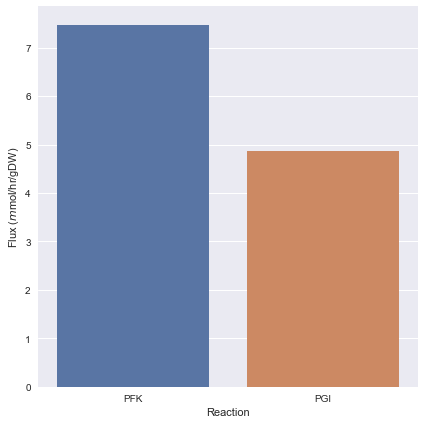

In [12]:
pFBA_result.plot(rxn_ids=["PFK", "PGI", "PGK"], aspect=1)

In [13]:
# perform flux sampling

sampling_result = pg_mod.do_flux_analysis(method="sampling", n=30)

Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp0u7xhswx.lp
Reading time = 0.01 seconds
: 73 rows, 190 columns, 722 nonzeros


In [14]:
sampling_result.result[0]

,rxn_id,flux
0,PFK,9.237147
1,PFL,0.004525
2,PGI,9.161558
3,PGK,-18.003960
4,PGL,0.695492
...,...,...
90,NADH16,33.370356
91,NADTRHD,0.119330
92,NH4t,3.589349
93,O2t,17.967234


## Create Group object

In [15]:
from pipeGEM.utils import random_perturb

In [16]:
# create different models
models = [random_perturb(ecoli, 
                         in_place=False, 
                         structure_ratio=0.8,
                         constr_ratio=0.8, 
                         random_state=i) for i in range(9)]

Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpl36r0snk.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpk1s067kx.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpjqsjeu_t.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpyo6wh5zn.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp6vpxjnnq.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmpabbbwe4m.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmp9i2mw1u0.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns

In [17]:
# The first way to initialize Group is to use a dict of cobra.model dicts (str as keys)

grp = pg.Group({"G1": {f"m{i+1}": models[i] for i in range(3)},
               "G2": {f"m{i+1}": models[i] for i in range(3, 6)},
               "G3": {f"m{i+1}": models[i] for i in range(6, 9)}}, name_tag="group")

In [18]:
# browse the group table

grp.get_info(features=["group_name", "n_rxns", "n_mets", "n_genes"])

,group_name,n_rxns,n_mets,n_genes
m1,G1,71,72,95
m2,G1,69,72,94
m3,G1,65,67,83
m4,G2,63,69,85
m5,G2,76,72,122
m6,G2,74,72,112
m7,G3,69,69,107
m8,G3,71,70,94
m9,G3,66,70,92


In [19]:
# The second way to initialize Group is to use a dict of pipeGEM.Model lists

grp = pg.Group({"G1": [pg.Model(f"m{i+1}", models[i]) for i in range(3)],
               "G2": [pg.Model(f"m{i+1}", models[i]) for i in range(3, 6)],
               "G3": [pg.Model(f"m{i+1}", models[i]) for i in range(6, 9)]}, name_tag="group")

In [20]:
# This should return the same result with the first case

grp.get_info(features=["group_name", "n_rxns", "n_mets", "n_genes"])

,group_name,n_rxns,n_mets,n_genes
m1,G1,71,72,95
m2,G1,69,72,94
m3,G1,65,67,83
m4,G2,63,69,85
m5,G2,76,72,122
m6,G2,74,72,112
m7,G3,69,69,107
m8,G3,71,70,94
m9,G3,66,70,92


## Group operations

In [21]:
# indexing

grp["m1"]

Name,e_coli_core
Memory address,0x02682216d700
Number of metabolites,72
Number of reactions,71
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [22]:
# select multiple models

grp[["m1", "m2", "m4"]].get_info()

,group_name,n_rxns,n_mets,n_genes
m1,G1,71,72,95
m2,G1,69,72,94
m4,G2,63,69,85


In [23]:
# aggregate models with thier group name into a dict

grp_dic = grp.aggregate_models("group_name")
grp_dic

{'G1': Group [G1] containing 3 models,
 'G2': Group [G2] containing 3 models,
 'G3': Group [G3] containing 3 models}

In [24]:
grp_dic["G2"].get_info()

,group_name,n_rxns,n_mets,n_genes
m4,G2,63,69,85
m5,G2,76,72,122
m6,G2,74,72,112


In [25]:
# The models inside the pg.Group are pg.Models

isinstance(grp_dic["G2"]["m4"], pg.Model)

True

In [26]:
grp = pg.Group([pg_mod, pg_mod.copy()], )
pfba_result = grp.do_flux_analysis(method="pFBA")

Read LP format model from file C:\Users\qwert\AppData\Local\Temp\tmprsboeryh.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros


In [27]:
pfba_result

    Reaction     fluxes  reduced_costs         model
0        PFK   7.477382      -2.000000         ecoli
1        PFL   0.000000       5.733333         ecoli
2        PGI   4.860861      -2.000000         ecoli
3        PGK -16.023526       2.000000         ecoli
4        PGL   4.959985      -2.000000         ecoli
..       ...        ...            ...           ...
185   NADH16  38.534610      -2.000000  copied_ecoli
186  NADTRHD   0.000000       1.422222  copied_ecoli
187     NH4t   4.765319      -2.000000  copied_ecoli
188      O2t  21.799493      -2.000000  copied_ecoli
189      PDH   9.282533      -2.000000  copied_ecoli

[190 rows x 4 columns]

In [58]:
pfba_result.log

{'name': 'Unnamed_group',
 'group': {'Unnamed_group': ['ecoli', 'copied_ecoli']},
 'group_annotation':               n_rxns  n_genes  n_mets
 ecoli             95      137      72
 copied_ecoli      95      137      72,
 'rxn_annotation':     subsystem
 PFK          }

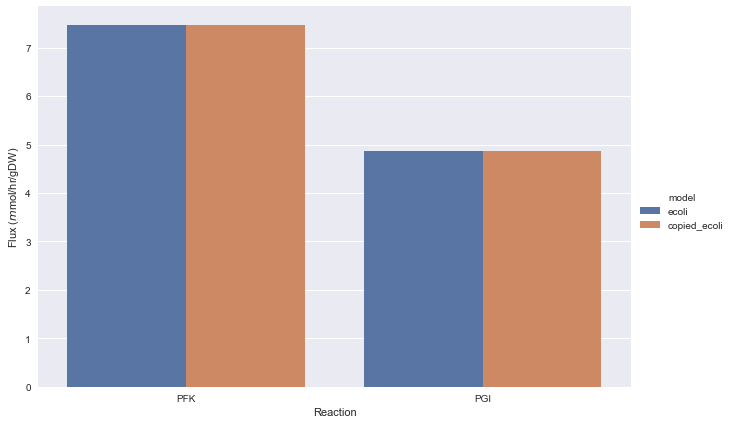

In [28]:
pfba_result.plot(rxn_ids=["PFK", "PGI", "PGK"], 
                 group_by="model", aspect=1.5, kind="bar")

## Comparisons

In [31]:
# compare model components
grp = pg.Group({"G1": [pg.Model(f"m{i+1}", models[i]) for i in range(3)],
               "G2": [pg.Model(f"m{i+1}", models[i]) for i in range(3, 6)],
               "G3": [pg.Model(f"m{i+1}", models[i]) for i in range(6, 9)]}, name_tag="group")
comparison = grp.compare(method="jaccard")

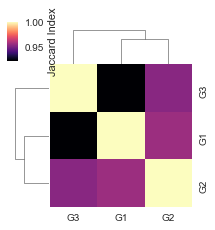

In [32]:
# visualization

comparison.plot()

In [33]:
# data frame showing the jaccard values
comparison

          G1        G2        G3
G1  1.000000  0.957237  0.924342
G2  0.957237  1.000000  0.953795
G3  0.924342  0.953795  1.000000

In [34]:
comparison = grp.compare(method="jaccard", group_by=None)

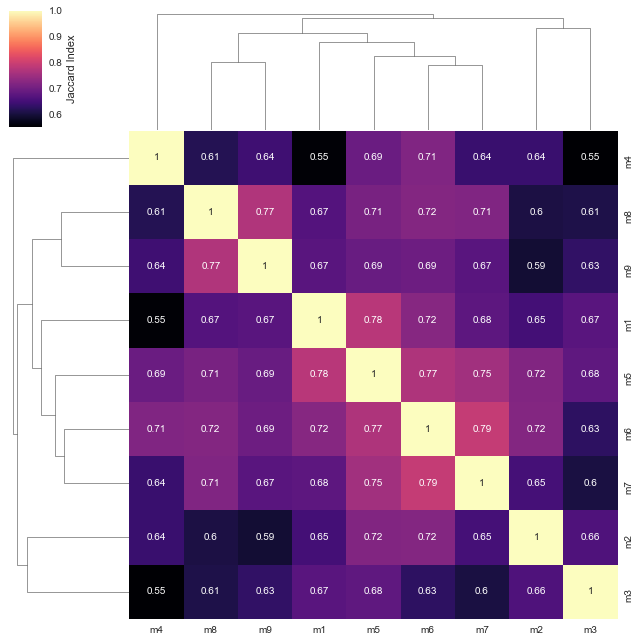

In [36]:
comparison.plot(annot=True)

In [41]:
comparison = grp.compare(method="PCA", group_by=None, n_components=3)

saving  PCA.png


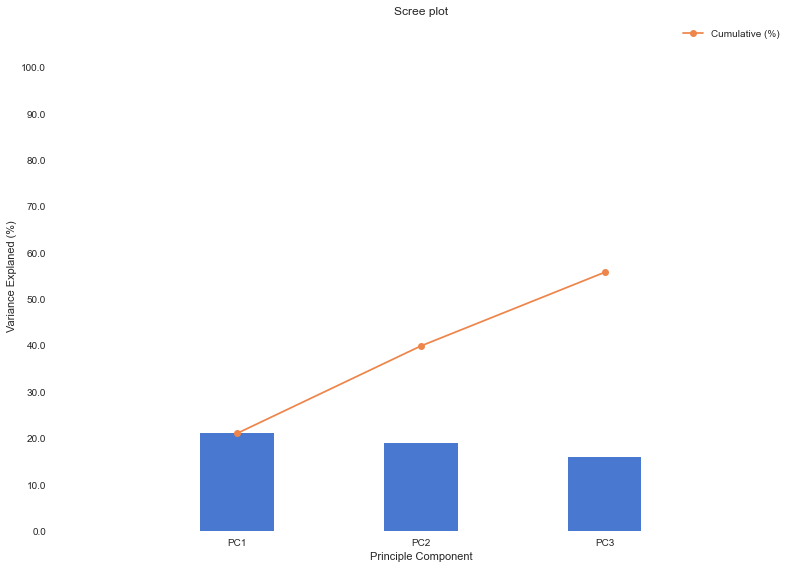

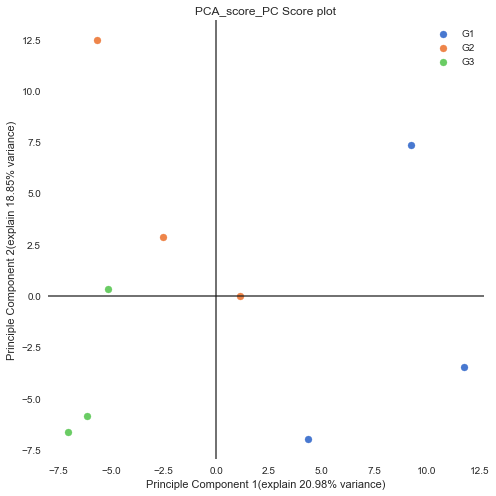

In [42]:
comparison.plot(file_name="PCA.png", prefix="")

In [43]:
comparison = grp.compare(group_by="group_name", method="num")

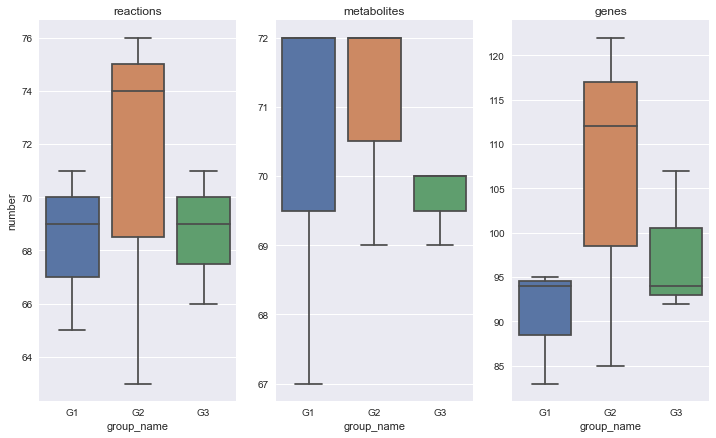

In [46]:
comparison.plot(name_order="default")